In [2]:
import sklearn as sk
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

import tensorflow.compat.v2.feature_column as fc

import tensorflow as tf

Loading dataset

In [3]:
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv') # training data
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv') # testing data
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

Check first 5 rows to see if data is loaded appropriately.

In [4]:
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [5]:
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [6]:
dftrain.shape

(627, 9)

In [7]:
y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: survived, dtype: int64

<Axes: >

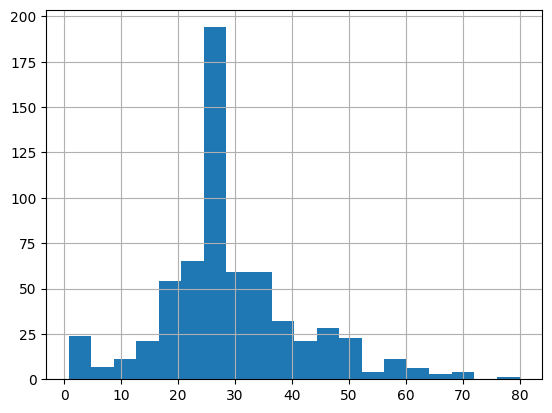

In [8]:
dftrain.age.hist(bins=20)

<Axes: ylabel='sex'>

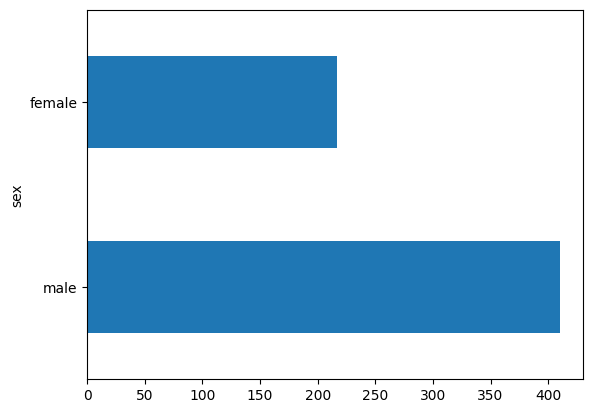

In [13]:
dftrain['sex'].value_counts().plot(kind='barh')

<Axes: ylabel='class'>

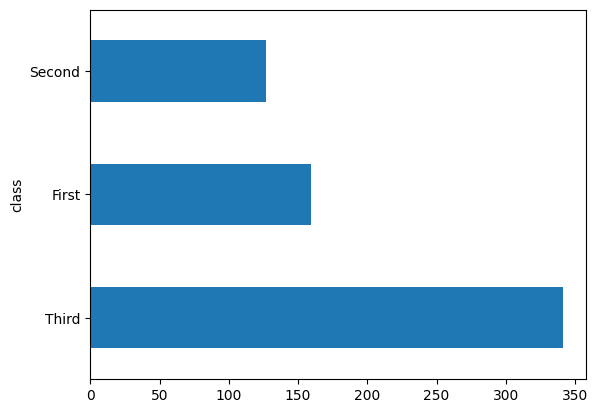

In [10]:
dftrain['class'].value_counts().plot(kind='barh')

Text(0.5, 0, '% survive')

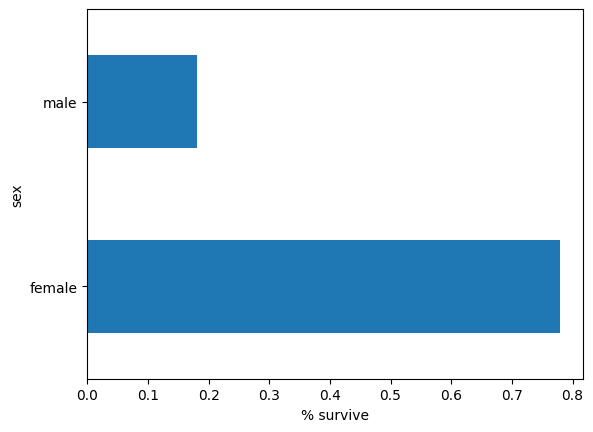

In [14]:
pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive')

Feature Column implementation

In [16]:
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

# Containers for the preprocessing layers
preprocessing_layers = {}

# Handle categorical features using StringLookup or IntegerLookup
for feature in CATEGORICAL_COLUMNS:
    unique_values = dftrain[feature].dropna().unique()

    if dftrain[feature].dtype == 'object':  # string/categorical data
        lookup = tf.keras.layers.StringLookup(vocabulary=unique_values, output_mode='one_hot')
    else:  # integer categorical data
        lookup = tf.keras.layers.IntegerLookup(vocabulary=unique_values, output_mode='one_hot')

    preprocessing_layers[feature] = lookup

# Handle numeric features using Normalization
for feature in NUMERIC_COLUMNS:
    normalizer = tf.keras.layers.Normalization()
    # Adapt the layer to the data (calculate mean & std for normalization)
    normalizer.adapt(np.array(dftrain[feature].dropna()))
    preprocessing_layers[feature] = normalizer
